In [2]:
%pip install torch

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 49.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:00
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from torch import *

In [ ]:
def distance(x, y):
    # eclidian distance

def conditions(x):
    """
    Check if nodes satisfy exchangeability conditions
    P({y_{i,j}: 1 < i < j < n} | x) = P({y_{\pi_i,\pi_j}: 1 < i < j < n} | x_{\pi})

    Can then be written as:
    y{i,j}=h(\mu, u_i, u_j, \epsilon_{i,j})

    where:
    h is a function that maps the parameters to the data
    """
    raise NotImplementedError

def h(mu, u_i, u_j, epsilon_ij):
    """
    h is a function that maps the parameters to the data
    and can be put in the form of:
    {epsilon_{i,j} ~ iid normal(0,1)
    {u_i, ..., u_n} ~ iid f(u|\psi)
    y{i,j}=h(\mu, u_i, u_j, \epsilon_{i,j}) = \delta{0,\infinty}(\mu + {alpha(u_i + u_j) + \epsilon_{i,j})

    where following parameters should be estimated:
    mu: location parameter
    alpha: scale parameter
    psi: distribution of u


    """
    raise NotImplementedError

In [ ]:
class LatentDistanceModel(Module):
    def __init__(self, n_nodes, dim, n_covariates):
       self.edges = []
       self.nodes = []
       self.weights = []
       self.beta = torch.randn((n_covariates,1))
       self.alpha = torch.randn((n_nodes, 1))
       self.z = torch.randn(n_nodes)

    def activity_level(self, alpha, beta, covariates):
        
    def linear_predictor(self, node_i, node_j, covariates):
        dist = torch.norm(node_i - node_j) #alpha(u_i, u_j)
        covariate_effect = covariates @ self.beta #beta^T (x_i,j)
        linear_predictor = covariate_effect - dist
        return linear_predictor
    
    def probit(self, node_i, node_j, covariates, linear_predictor): 
        normal_dist = dist.normal(0,1)
        return normal_dist.cdf(linear_predictor(node_i, node_j, covariates))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [27]:
class LDM_ordinal_probit(nn.Module):
    def __init__(self, n_drugs, n_effects, dim, n_levels):
        super().__init__()
        self.drug_embeddings = nn.Embedding(n_drugs, dim)
        self.effect_embeddings = nn.Embedding(n_effects, dim)
        self.psi = nn.Parameter(torch.zeros(n_drugs))  # Drug random effects
        self.omega = nn.Parameter(torch.zeros(n_effects))  # Side effect random effects
        self.thresholds = nn.Parameter(torch.linspace(-2, 2, n_levels - 1))  # Learnable thresholds
        self.normal_cdf = torch.distributions.Normal(0, 1).cdf

    def forward(self, drug_idx, effect_idx):
        drug_vec = self.drug_embeddings(drug_idx)
        effect_vec = self.effect_embeddings(effect_idx)
        distance = torch.norm(drug_vec - effect_vec, dim=1)  # Euclidean distance
        latent_score = self.psi[drug_idx] + self.omega[effect_idx] - distance  # Latent variable

        # Compute cumulative probabilities for ordinal levels
        cdf_values = self.normal_cdf(latent_score.unsqueeze(1) - self.thresholds)
        prob_levels = torch.cat([cdf_values[:, :1], cdf_values[:, 1:] - cdf_values[:, :-1], 1 - cdf_values[:, -1:]], dim=1)
        return prob_levels  # Returns probability distribution over frequency levels

# Example setup
n_drugs = 100  
n_effects = 200  
dim = 10  
n_levels = 4  

model = LDM_ordinal_probit(n_drugs, n_effects, dim, n_levels)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()  

# Example training batch
drug_batch = torch.randint(0, n_drugs, (32,))
effect_batch = torch.randint(0, n_effects, (32,))
frequency_labels = torch.randint(0, n_levels, (32,))  

# Forward pass
probs = model(drug_batch, effect_batch)
loss = loss_fn(probs, frequency_labels)

# Backward pass
optimizer.zero_grad()
loss.backward()
optimizer.step()


In [28]:
def validate(model, validation_data, loss_fn):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad(): # ikke helt sikker
        for drug_batch, effect_batch, frequency_labels in validation_data:
            probs = model(drug_batch, effect_batch)
            loss = loss_fn(probs, frequency_labels)
            total_loss += loss.item()
            predicted_levels = probs.argmax() # her er der noget der går galt?
            total_correct += (predicted_levels == frequency_labels).sum().item()
    
    avg_loss = total_loss / len(validation_data)
    accuracy = total_correct / len(validation_data) #output virker underligt
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

validation_data = [(drug_batch, effect_batch, frequency_labels)] 
validate(model, validation_data, loss_fn)

def train(model, train_data, validation_data, optimizer, loss_fn, num_epochs=10):
    for epoch in range(num_epochs):
        model.train() 
        total_loss = 0
        for drug_batch, effect_batch, frequency_labels in train_data:
            optimizer.zero_grad()
            probs = model(drug_batch, effect_batch)
            loss = loss_fn(probs, frequency_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_data)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_loss:.4f}")
        validate(model, validation_data, loss_fn)


train_data = [(drug_batch, effect_batch, frequency_labels)]  
validation_data = [(drug_batch, effect_batch, frequency_labels)] 
train(model, train_data, validation_data, optimizer, loss_fn, num_epochs=10)

# Save model
torch.save(model.state_dict(), "ldm_model.pth")

# Load model
model = LDM_ordinal_probit(n_drugs, n_effects, dim, n_levels)
model.load_state_dict(torch.load("ldm_model.pth"))



Validation Loss: 1.4504, Accuracy: 10.0000
Epoch 1/10, Average Training Loss: 1.4504
Validation Loss: 1.4487, Accuracy: 10.0000
Epoch 2/10, Average Training Loss: 1.4487
Validation Loss: 1.4471, Accuracy: 10.0000
Epoch 3/10, Average Training Loss: 1.4471
Validation Loss: 1.4456, Accuracy: 10.0000
Epoch 4/10, Average Training Loss: 1.4456
Validation Loss: 1.4441, Accuracy: 10.0000
Epoch 5/10, Average Training Loss: 1.4441
Validation Loss: 1.4427, Accuracy: 10.0000
Epoch 6/10, Average Training Loss: 1.4427
Validation Loss: 1.4413, Accuracy: 10.0000
Epoch 7/10, Average Training Loss: 1.4413
Validation Loss: 1.4399, Accuracy: 10.0000
Epoch 8/10, Average Training Loss: 1.4399
Validation Loss: 1.4386, Accuracy: 10.0000
Epoch 9/10, Average Training Loss: 1.4386
Validation Loss: 1.4373, Accuracy: 10.0000
Epoch 10/10, Average Training Loss: 1.4373
Validation Loss: 1.4360, Accuracy: 10.0000


<All keys matched successfully>

In [3]:
import torch
import torch.nn.functional as F
from torch.distributions import Normal

In [31]:
drug_ids = torch.tensor([0, 0, 1, 2, 3])  # Drugs
side_effect_ids = torch.tensor([5, 8, 3, 5, 4])  # Side effects
edges = torch.vstack((drug_ids, side_effect_ids))
frequency_levels = torch.tensor([1, 2, 3, 2, 1])
edges, frequency_levels

(tensor([[0, 0, 1, 2, 3],
         [5, 8, 3, 5, 4]]),
 tensor([1, 2, 3, 2, 1]))

In [40]:
def get_neg_likelihood(edges, frequency_levels, beta_p_star, beta_p, p, p_star, mu):
    
    #linear predictor
    betas = torch.index_select(beta_p_star, 0, edges[0]) - torch.index_select(beta_p, 0, edges[1])
    z_dist = torch.norm(torch.index_select(p, index=edges[0], dim=0) -
                        torch.index_select(p_star, index=edges[1], dim=0), dim=1)
    
    linear_predictor = betas - z_dist

    normal_dist = Normal(0, 1)

    lower_bound = normal_dist.cdf(linear_predictor - mu[frequency_levels])
    upper_bound = normal_dist.cdf(linear_predictor - mu[frequency_levels - 1])

    prob = upper_bound - lower_bound
    neg_likelihood = -torch.log(prob).sum()
    return neg_likelihood

num_drugs = 10
num_side_effects = 10
num_edges = 20
latent_dim = 3

edges = torch.randint(0, num_drugs, (2, num_edges))  #  (drug, side effect) pairs
frequency_levels = torch.randint(1, 4, (num_edges,))  # ordinal levels

beta_p_star = torch.randn(num_drugs)  # Drug coefficients
beta_p = torch.randn(num_side_effects)  # Side effect coefficients

p = torch.randn(num_drugs, latent_dim)  # latent space
p_star = torch.randn(num_side_effects, latent_dim)  #Side effect latent space

mu = torch.tensor([-1.0, 0.0, 1.0, 2.0])  #thresholds

#loss
loss = get_neg_likelihood(edges, frequency_levels, beta_p_star, beta_p, p, p_star, mu)
print("edges:", edges)
print("Frequency Levels:", frequency_levels)
print("beta_p_star:", beta_p_star)
print("beta_p:", beta_p)
print("p:", p)
print("p_star:", p_star)
print("mu:", mu)
print("Negative Log-Likelihood Loss:", loss)

edges: tensor([[3, 4, 0, 7, 3, 8, 2, 1, 4, 5, 6, 2, 2, 7, 0, 1, 8, 5, 7, 0],
        [7, 8, 2, 8, 6, 5, 3, 1, 6, 5, 0, 8, 2, 5, 6, 5, 0, 9, 9, 5]])
Frequency Levels: tensor([3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 2, 2, 1, 3, 3, 1, 1, 1, 2, 1])
beta_p_star: tensor([ 0.6151,  0.5619,  0.7123,  1.1925,  1.0980, -2.0061,  0.2125,  0.0629,
         2.3210,  0.3839])
beta_p: tensor([ 0.4126, -0.0793,  0.5133, -1.9106,  0.6564,  0.2694, -0.1853,  1.3706,
         1.6282,  1.0462])
p: tensor([[-9.8484e-01, -3.3148e-01, -9.1045e-01],
        [-6.9898e-01,  6.0512e-01,  1.6498e-01],
        [-9.0738e-01,  1.6804e+00,  2.0747e-01],
        [ 1.0680e+00,  4.5732e-01, -9.8129e-01],
        [ 1.9390e-01, -9.8052e-01,  1.0743e+00],
        [ 7.8802e-01,  1.3255e+00, -1.1842e+00],
        [ 1.7219e-01,  6.7675e-01,  4.2031e-01],
        [-1.2721e+00,  2.8494e-01, -1.8926e-02],
        [ 4.3571e-01,  1.9544e-01, -1.1714e-01],
        [-1.1968e-03,  3.5992e-01,  5.7093e-01]])
p_star: tensor([[-0.3168, -0.2834, -

In [34]:
import torch
import torch.nn as nn
from torch.distributions import Normal

class LDMprobit(torch.nn.Module):
    def __init__(self, Aij, thresholds, embedding_dim, device, n_epochs): #magler noget at initialisere nn med 
        super(LDMprobit, self).__init__()
        self.Aij = Aij.to(device)
        self.thresholds = thresholds.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = (len(thresholds) - 1)

        #Variables for the learning process
        self.n_epochs = n_epochs


        #parameters to be learned
        self.beta = nn.Parameter(torch.randn(self.n_drugs, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim))  # Latent embeddings for side effects
    
    def get_embeddings(self):
        return self.w, self.v

    def probit(self):
        #n_ordinal_classes = len(self.thresholds) - 1
        #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_drugs, self.n_effects, self.n_ordinal_classes))

    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta)

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - self.thresholds[y]
            z2 = latent_var - self.thresholds[y+1]
            probit_matrix[:, :, y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # Iterate over all drugs and side effects
        for i in range(self.Aij.shape[0]):  # For each drug
            for j in range(self.Aij.shape[1]):  # For each side effect
                if self.Aij[i, j] != 0:  # Only compute loss for nonzero entries
                    target_class = int(self.Aij[i, j]) - 1  # Convert severity to class (0-based)
                    
                    # One-hot encode target for the current entry
                    one_hot_target = torch.zeros(self.n_ordinal_classes, device=device)
                    one_hot_target[target_class] = 1  # Set the correct class to 1
                    

                    # Compute the log-likelihood for this entry
                    prob = probit_matrix[i, j]
                    loss -= torch.log(torch.sum(prob * one_hot_target) + 1e-8)  # Negative log-likelihood

        return loss
        
    def learn(self):
        for epoch in range(self.n_epochs):
            self.train_one_epoch()
        return self.ordinal_cross_entropy_loss()
    
    def train_one_epoch(self):
        raise NotImplementedError

    def train_one_batch(self):
        raise NotImplementedError

    def forward():
        raise NotImplementedError

    def get_params():
        raise NotImplementedError

    def save_embeddings():
        raise NotImplementedError

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 3
Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
                    [0, 0, 3, 1, 2, 0],
                    [1, 0, 0, 2, 1, 3],
                    [0, 0, 0, 0, 1, 2],
                    [3, 3, 0, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
thresholds = torch.tensor([0, 1, 2,3], dtype=torch.float32, device=device) 
model = LDMprobit(Aij, thresholds, embedding_dim, device)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.ordinal_cross_entropy_loss()  # Compute the ordinal cross-entropy loss
print(loss_out)

TypeError: LDMprobit.__init__() missing 1 required positional argument: 'n_epochs'

In [20]:
loss_out = model.ordinal_cross_entropy_loss()  # Compute the ordinal cross-entropy loss
print(loss_out)

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [22]:
embeddings = model.get_embeddings()  # Get the learned embeddings
print("Drug Embeddings:\n",embeddings)

Drug Embeddings:
 (Parameter containing:
tensor([[-1.1665, -1.5025, -0.2053],
        [ 1.6568,  0.8507, -0.3650],
        [-0.9950, -0.0809, -0.7186],
        [ 0.8092, -0.4694,  0.8674],
        [-0.9870, -1.7491,  1.0859],
        [-0.3351, -0.5005,  0.0268]], requires_grad=True), Parameter containing:
tensor([[-0.0258,  0.6842, -0.7326],
        [ 0.3903, -0.8252,  0.9820],
        [ 1.6791,  0.6757,  0.6980],
        [-0.6344, -0.4620,  0.5783],
        [ 0.5592,  0.4803,  0.1994],
        [ 1.3699, -2.0747,  0.2325]], requires_grad=True))


In [14]:
torch.randn(Aij.shape[1])

tensor([-0.6203, -0.8858, -0.1669, -2.3713, -0.1596,  0.1946])

In [29]:
def probit(edges, x, u_i, u_j, beta, thresholds, device):

    num_classes = len(thresholds) - 1
    normal_dist = Normal(0, 1)

    for edge in edges:
        i,j = edge

        # Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(x[i], beta)

        # Distance term \alpha(u_i - u_j) altså her -|u_i - u_j|
        dist = - torch.norm(u_i[i] - u_j[j])

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist

        for k in range(num_classes):
            # thresholds, altså b_o,...b_n
            lower_threshold = thresholds[k]
            upper_threshold = thresholds[k + 1]
            
            # Selve probit
            prob_k = normal_dist.cdf(upper_threshold - latent_var) - normal_dist.cdf(lower_threshold - latent_var)

    return prob_k

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
edges = [(0, 1), (2, 3)]
#non   # List of drug-side effect pairs
x = torch.randn(10, 3).to(device)  # x, feature matrix/covariates
u_i = torch.randn(10, 1).to(device)  # vector med drugs
u_j = torch.randn(10, 1).to(device)  # vector med side effects
beta = torch.randn(3).to(device)  # beta vector, skal estimeres
thresholds = [-1.0, 0.0, 1.0]  #Værdier for ordinal categories

prob = probit(edges, x, u_i, u_j, beta, thresholds, device)
print(f"Probability: {prob.item()}")
print(prob)

Linear term: -0.013394832611083984
Distance term: -0.7636815309524536
Latent variable: -0.7770763635635376
Linear term: 5.425067901611328
Distance term: -2.53249454498291
Latent variable: 2.892573356628418
Probability: 0.02729669213294983
tensor(0.0273)


In [6]:
# Dummy variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 3
Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
                    [0, 0, 3, 1, 2, 0],
                    [1, 0, 0, 2, 1, 3],
                    [0, 0, 0, 0, 1, 2],
                    [3, 3, 0, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
beta = torch.randn(6)
thresholds = torch.tensor([-1.0, 0.0, 1.0], dtype=torch.float).to(device)
w = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for drugs
v = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for side effects


In [15]:
def probit(Aij, beta, thresholds, w, v, device):
    n_ordinal_classes = len(thresholds) - 1
    n_drugs, n_effects = Aij.shape
    normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
    #probit_matrix = torch.zeros((n_drugs, n_effects, n_ordinal_classes))

  
    #Linear term (\beta^T x_{i,j})
    linear_term = torch.matmul(Aij, beta)

    # Distance term -|w_i - v_j|
    dist = -torch.norm(w.unsqueeze(1) - v.unsqueeze(0), dim=2)

    # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
    latent_var = linear_term + dist
    
    z1 = (latent_var.unsqueeze(-1) - thresholds[:-1])
    z2 = (latent_var.unsqueeze(-1) - thresholds[1:])
    probit_matrix = normal_dist.cdf(z1) - normal_dist.cdf(z2)
    
    return probit_matrix
    
# embedding_dim = 3
# Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
#                     [0, 0, 3, 1, 2, 0],
#                     [1, 0, 0, 2, 1, 3],
#                     [0, 0, 0, 0, 1, 2],
#                     [3, 3, 0, 0, 0, 1],
#                     [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
# beta = torch.randn(6)
# thresholds = torch.tensor([-1.0, 0.0, 1.0], dtype=torch.float).to(device)
# w = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for drugs
# v = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for side effects
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

probs= probit(Aij, beta, thresholds,w,v, device)
probs

tensor([[[1.0729e-02, 5.0616e-04],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [8.9407e-08, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[4.9962e-03, 1.8042e-04],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [5.9605e-08, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.6557e-03, 4.2170e-05],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.1514e-02, 5.5754e-04],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[2.4735e-03, 7.1228e-05],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [5.9605e-08, 0.0000e+00],
         [0.

In [7]:
def probit(Aij, beta, thresholds, w, v, device):
    n_ordinal_classes = len(thresholds) - 1
    n_drugs, n_effects = Aij.shape
    normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
    probit_matrix = torch.zeros((n_drugs, n_effects, n_ordinal_classes))

  
    #Linear term (\beta^T x_{i,j})
    linear_term = torch.matmul(Aij, beta)

    # Distance term -|w_i - v_j|
    dist = -torch.norm(w.unsqueeze(1) - v.unsqueeze(0), dim=2)

    # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
    latent_var = linear_term + dist
    
    for y in range(n_ordinal_classes):
        z1 = latent_var - thresholds[y]
        z2 = latent_var - thresholds[y+1]
        probit_matrix[:, :, y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
    
    return probit_matrix
    
# embedding_dim = 3
# Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
#                     [0, 0, 3, 1, 2, 0],
#                     [1, 0, 0, 2, 1, 3],
#                     [0, 0, 0, 0, 1, 2],
#                     [3, 3, 0, 0, 0, 1],
#                     [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
# beta = torch.randn(6)
# thresholds = torch.tensor([-1.0, 0.0, 1.0], dtype=torch.float).to(device)
# w = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for drugs
# v = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for side effects
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

probs= probit(Aij, beta, thresholds,w,v, device)
probs

tensor([[[0.0000e+00, 0.0000e+00],
         [5.9605e-08, 0.0000e+00],
         [1.6391e-06, 0.0000e+00],
         [2.6995e-02, 1.8317e-03],
         [4.4286e-05, 4.4703e-07],
         [1.6847e-04, 2.2948e-06]],

        [[2.0862e-07, 0.0000e+00],
         [4.5360e-03, 1.5861e-04],
         [3.7578e-02, 2.9480e-03],
         [2.3842e-06, 0.0000e+00],
         [2.0552e-04, 2.9206e-06],
         [4.9396e-03, 1.7768e-04]],

        [[4.1723e-07, 0.0000e+00],
         [7.9215e-05, 8.9407e-07],
         [2.1911e-03, 6.0767e-05],
         [3.6060e-02, 2.7767e-03],
         [4.2711e-03, 1.4642e-04],
         [2.3994e-03, 6.8456e-05]],

        [[1.1772e-04, 1.4901e-06],
         [1.6600e-03, 4.2319e-05],
         [4.4671e-02, 3.7960e-03],
         [1.0975e-03, 2.4796e-05],
         [4.1938e-03, 1.4290e-04],
         [2.2289e-03, 6.2168e-05]],

        [[3.1292e-06, 2.9802e-08],
         [1.0860e-02, 5.1460e-04],
         [2.4919e-02, 1.6347e-03],
         [2.9981e-04, 4.7386e-06],
         [1.

In [24]:
import torch.nn.functional as F

def ordinal_cross_entropy_loss(Aij, beta, thresholds, w, v, n_ordinal_classes, device):
    # Compute the predicted probabilities using the probit function
    probit_matrix = probit(Aij, beta, thresholds, w, v, device)

    # Initialize loss variable
    loss = 0.0

    # Iterate over all drugs and side effects
    for i in range(Aij.shape[0]):  # For each drug
        for j in range(Aij.shape[1]):  # For each side effect
            if Aij[i, j] != 0:  # Only compute loss for nonzero entries
                target_class = int(Aij[i, j]) - 1  # Convert severity to class (0-based)
                
                # One-hot encode target for the current entry
                one_hot_target = torch.zeros(n_ordinal_classes, device=device)
                one_hot_target[target_class] = 1  # Set the correct class to 1
                

                # Compute the log-likelihood for this entry
                prob = probit_matrix[i, j]
                loss -= torch.log(torch.sum(prob * one_hot_target) + 1e-8)  # Negative log-likelihood

    return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
                    [0, 0, 3, 1, 2, 0],
                    [1, 0, 0, 2, 1, 3],
                    [0, 0, 0, 0, 1, 2],
                    [3, 3, 0, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32)

beta = torch.randn(6)  
embedding_dim = 3
thresholds = torch.tensor([0, 1, 2, 3], device=device)  # Define your thresholds
w = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))  # Latent embeddings for drugs
v = torch.nn.Parameter(torch.randn(Aij.shape[0], embedding_dim))   # Define latent variable for side effects
targets = Aij  # The actual data in Aij
n_ordinal_classes = 3  # For severity levels 1-3


# Compute the loss
loss = ordinal_cross_entropy_loss(Aij, beta, thresholds, w, v, n_ordinal_classes, device)
print(f"Loss: {loss.item()}")

Loss: 134.05015563964844


In [191]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class LDMprobit(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=0):
        super(LDMprobit, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item()

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    
    def get_thresholds(self):
        thresholds = torch.cumsum(torch.softmax(self.beta_thilde, dim=0), dim=0) * torch.abs(self.a) - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])

    def probit(self):
        #n_ordinal_classes = len(self.thresholds) - 1
        #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_drugs, self.n_effects, self.n_ordinal_classes), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[:, :, y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # Iterate over all drugs and side effects
        for i in range(self.n_drugs):  # For each drug
            for j in range(self.n_effects):  # For each side effect
                if self.Aij[i, j] != 0:  # Only compute loss for nonzero entries
                    target_class = int(self.Aij[i, j]) - 1  # Convert severity to class (0-based)
                    
                    #One-hot encode target 
                    one_hot_target = torch.zeros(self.n_ordinal_classes, device=self.device)
                    one_hot_target[target_class] = 1  # Set the correct class to 1

                    # Compute the log-likelihood 
                    prob = probit_matrix[i, j]
                    loss -= torch.log(torch.sum(prob * one_hot_target) + 1e-8)  # Negative log-likelihood, addition of small number to avoid log(0)

        return loss
    
    def forward(self):
        return self.probit()
        
    def learn(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        for epoch in range(self.n_epochs):
            avg_loss = self.train_one_epoch(optimizer)
            print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {avg_loss:.4f}")
        print(f"Gradients of w: {model.w.grad}")
        print(f"Gradients of v: {model.v.grad}")
        return self.ordinal_cross_entropy_loss()

    
    def train_one_epoch(self, optimizer, batch_size=32):
        total_loss = 0
        n_batches = (self.n_drugs + batch_size - 1) // batch_size
        for _ in range(n_batches):
            batch_loss = self.train_one_batch(optimizer)
            total_loss += batch_loss
        return total_loss / n_batches
    

    def train_one_batch(self, optimizer):
        optimizer.zero_grad()
        loss = self.ordinal_cross_entropy_loss()
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def plot_network(self):
        G = nx.Graph()

        # Get embeddings (drug and effect embeddings)
        drug_embeddings = self.w.detach().cpu().numpy()  # (n_drugs, embedding_dim)
        effect_embeddings = self.v.detach().cpu().numpy()  # (n_effects, embedding_dim)

        # Add nodes for drugs and side effects
        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        # Calculate the probability matrix using the probit function
        probit_matrix = self.probit()

        # Add edges based on the probit matrix (non-zero probability indicates a link)
        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                prob = probit_matrix[i, j].max().item()  # Use the max probability for this drug-effect pair
                if prob > 0.01:  # Threshold for displaying an edge
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=prob)

        # Create a layout based on the embeddings
        pos = {}
        
        # Position drugs based on their embeddings
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drug_embeddings[i, 0], drug_embeddings[i, 1])  # 2D position based on first two embedding dims
        
        # Position effects based on their embeddings
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effect_embeddings[j, 0], effect_embeddings[j, 1])

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=["blue" if "Drug" in node else "red" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (probabilities) as labels
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network based on Embeddings and Probit Output')
        plt.show()

    def plot_links(self):
        G = nx.Graph()

        # Add nodes for drugs and side effects
        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        # Calculate the probability matrix using the probit function
        probit_matrix = self.probit()

        # Add edges based on the probit matrix (non-zero probability indicates a link)
        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                prob = probit_matrix[i, j].max().item()  # Use the max probability for this drug-effect pair
                if prob > 0.35:  # Threshold for displaying an edge
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=prob)

        pos = {}
        pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(self.n_drugs)))  # Position for drugs
        pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(self.n_effects)))  # Position for effects

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (optional)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network')
        plt.show()

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 4
Aij = torch.tensor([[3, 0, 0, 0, 1, 0], 
                    [0, 0, 0, 0, 1, 2],
                    [0, 3, 0, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 100
lr = 0.001
seed = 42
model = LDMprobit(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
final_loss = model.learn()
print("\nFinal Loss after training:", final_loss.item())

Epoch 1/100, Loss: 34.7426
Epoch 2/100, Loss: 34.6291
Epoch 3/100, Loss: 34.5173
Epoch 4/100, Loss: 34.4056
Epoch 5/100, Loss: 34.2965
Epoch 6/100, Loss: 34.1843
Epoch 7/100, Loss: 34.0692
Epoch 8/100, Loss: 33.9601
Epoch 9/100, Loss: 33.8485
Epoch 10/100, Loss: 33.7395
Epoch 11/100, Loss: 33.6283
Epoch 12/100, Loss: 33.5206
Epoch 13/100, Loss: 33.4127
Epoch 14/100, Loss: 33.3056
Epoch 15/100, Loss: 33.1944
Epoch 16/100, Loss: 33.0906
Epoch 17/100, Loss: 32.9814
Epoch 18/100, Loss: 32.8748
Epoch 19/100, Loss: 32.7707
Epoch 20/100, Loss: 32.6648
Epoch 21/100, Loss: 32.5606
Epoch 22/100, Loss: 32.4522
Epoch 23/100, Loss: 32.3503
Epoch 24/100, Loss: 32.2458
Epoch 25/100, Loss: 32.1431
Epoch 26/100, Loss: 32.0410
Epoch 27/100, Loss: 31.9368
Epoch 28/100, Loss: 31.8345
Epoch 29/100, Loss: 31.7336
Epoch 30/100, Loss: 31.6319
Epoch 31/100, Loss: 31.5321
Epoch 32/100, Loss: 31.4307
Epoch 33/100, Loss: 31.3321
Epoch 34/100, Loss: 31.2322
Epoch 35/100, Loss: 31.1329
Epoch 36/100, Loss: 31.0350
E

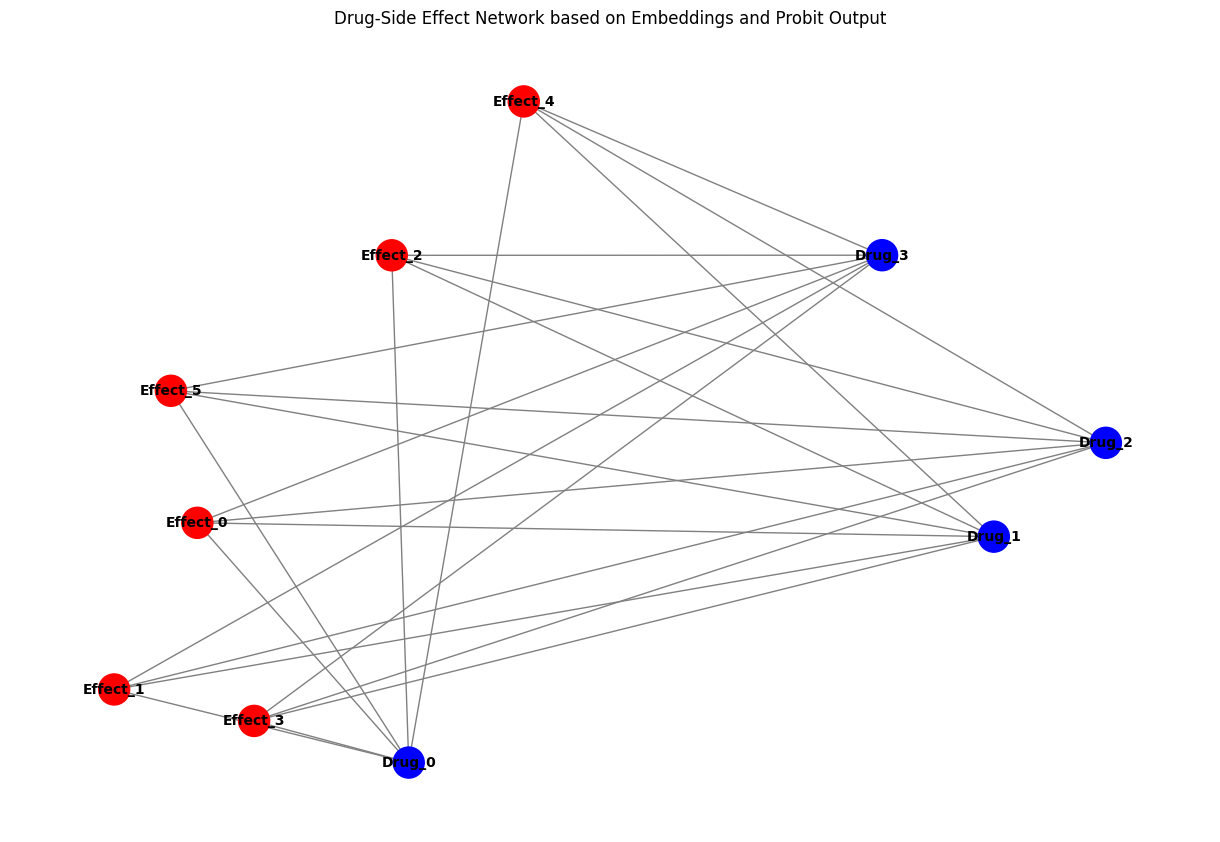

In [195]:
model.plot_network()

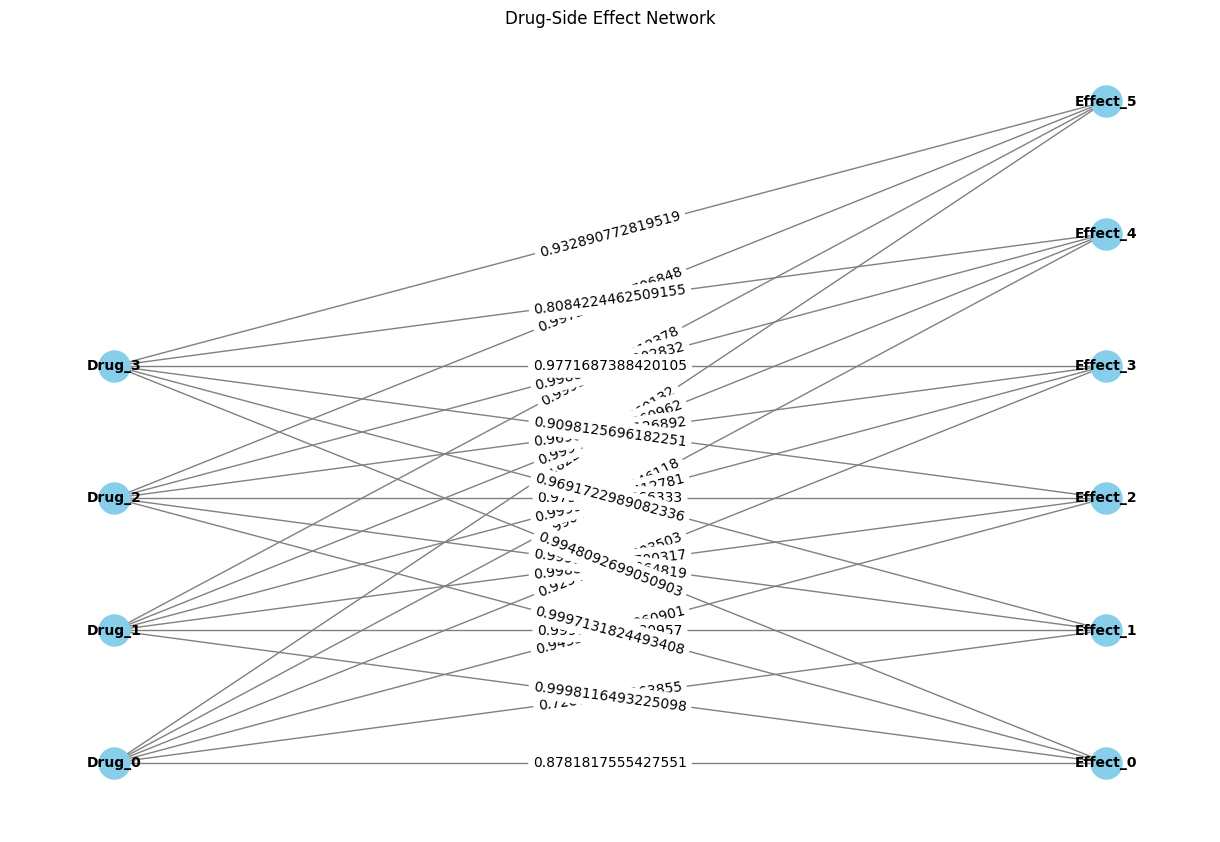

In [196]:
model.plot_links()

In [197]:
model.get_thresholds()

tensor([   -inf, -0.7538, -0.6926, -0.5435,     inf], grad_fn=<CatBackward0>)

In [198]:
beta, w, v, beta_tilde = model.get_params()
beta, w, v, beta_tilde

(Parameter containing:
 tensor([ 0.4289,  0.2252,  0.3286,  0.2303, -1.0274, -0.0895],
        requires_grad=True),
 array([[-0.33930683, -1.1162475 , -0.57075894,  0.4296188 ],
        [ 1.544902  , -0.06513264, -0.5895955 ,  0.48803657],
        [ 1.9056866 ,  0.37126264,  1.4772328 , -0.8263745 ],
        [ 1.185035  ,  1.2441266 ,  0.5168567 ,  1.2403603 ]],
       dtype=float32),
 array([[-1.0199403e+00, -8.2571385e-04, -2.2237682e+00, -1.2657690e-01],
        [-1.2879124e+00, -7.7607363e-01, -1.2751788e-01,  1.6208872e+00],
        [-3.9390275e-01,  1.2436655e+00, -7.2039783e-01, -6.4161533e-01],
        [-8.3712512e-01, -9.2239010e-01,  1.8113172e+00,  1.6056493e-01],
        [ 3.1193528e-02,  1.9595463e+00, -1.2999955e+00,  1.5016941e+00],
        [-1.1050507e+00,  6.1333406e-01, -9.8380446e-01,  4.8812601e-01]],
       dtype=float32),
 array([-1.1152779 , -0.7914495 ,  0.09842883], dtype=float32))

In [103]:
#100
beta, w, v, wc, vc, wcn, vcn = model.get_params()
beta, w, v, wc, vc, wcn, vcn 

(Parameter containing:
 tensor([ 0.5259,  0.1963,  0.4422, -0.3511,  1.9226,  0.7380],
        requires_grad=True),
 tensor([[-0.6787,  0.5113,  0.5635,  1.9154],
         [ 0.2834,  0.5949,  0.3644,  1.3275],
         [ 0.3208, -0.0592, -0.1080,  0.9223],
         [ 0.2126,  0.7963,  0.1560, -0.2917]]),
 tensor([[ 0.3037, -0.7188,  0.7909, -0.2410],
         [ 0.4150,  0.3737, -0.3394,  0.4947],
         [ 0.2126,  0.7866, -0.1205, -0.3145],
         [-0.7149,  0.4992,  0.3120,  0.3709],
         [ 0.0184,  0.6677,  0.4651, -0.5807],
         [-0.3098,  0.4734, -0.9820,  1.7816]]),
 tensor([[-0.6787,  0.5113,  0.5635,  1.9154],
         [ 0.2834,  0.5949,  0.3644,  1.3275],
         [ 0.3208, -0.0592, -0.1080,  0.9223],
         [ 0.2126,  0.7963,  0.1560, -0.2917]]),
 tensor([[ 0.3037, -0.7188,  0.7909, -0.2410],
         [ 0.4150,  0.3737, -0.3394,  0.4947],
         [ 0.2126,  0.7866, -0.1205, -0.3145],
         [-0.7149,  0.4992,  0.3120,  0.3709],
         [ 0.0184,  0.6677,  0.4

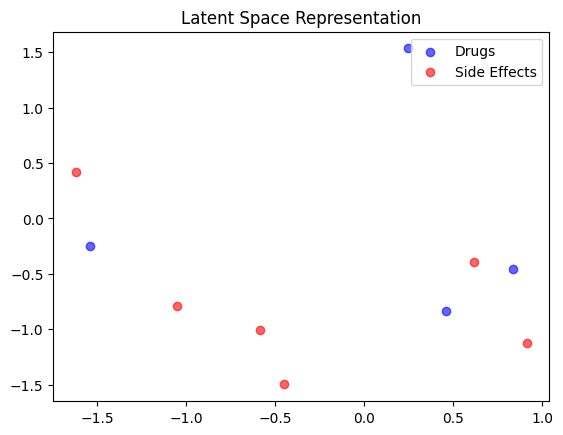

In [199]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality
pca = PCA(n_components=2)
w_2d = pca.fit_transform(wcn)  # (N1, 2)
v_2d = pca.transform(vcn)  # (N2, 2)

# Plot
plt.scatter(w_2d[:, 0], w_2d[:, 1], label="Drugs", color='blue', alpha=0.6)
plt.scatter(v_2d[:, 0], v_2d[:, 1], label="Side Effects", color='red', alpha=0.6)
plt.legend()
plt.title("Latent Space Representation")
plt.show()


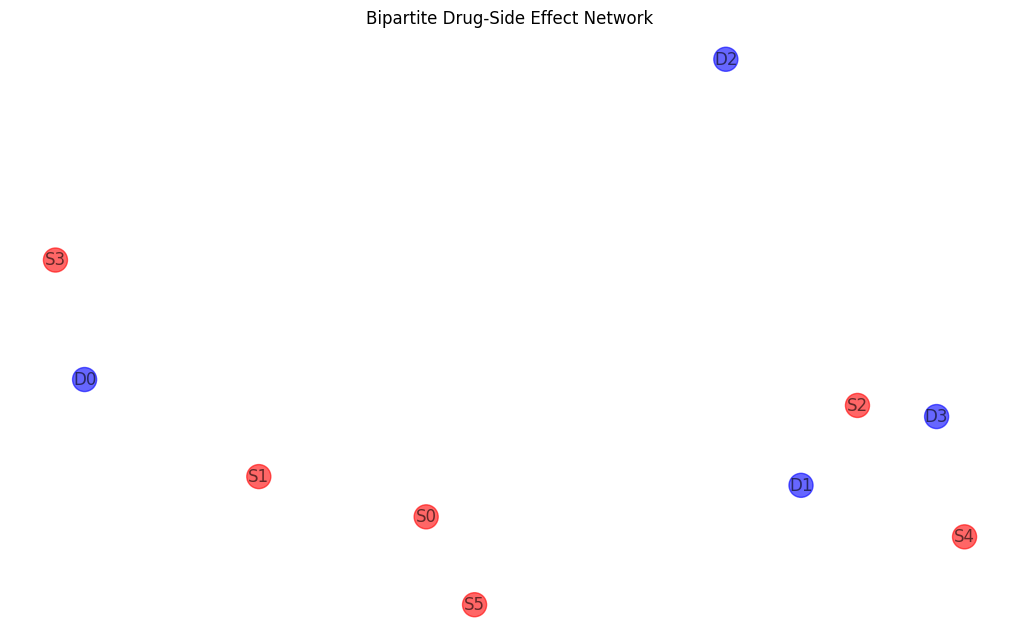

In [200]:
import networkx as nx
import numpy as np
G = nx.Graph()

# Add drug nodes
for i in range(wcn.shape[0]):
    G.add_node(f"D{i}", bipartite=0, pos=w_2d[i])

# Add side effect nodes
for j in range(vcn.shape[0]):
    G.add_node(f"S{j}", bipartite=1, pos=v_2d[j])

pos = nx.get_node_attributes(G, "pos")

# Draw network
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color=["blue" if "D" in node else "red" for node in G.nodes], edge_color="gray", alpha=0.6)
plt.title("Bipartite Drug-Side Effect Network")
plt.show()

In [202]:
Aij

tensor([[3., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 2.],
        [0., 3., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0.]])

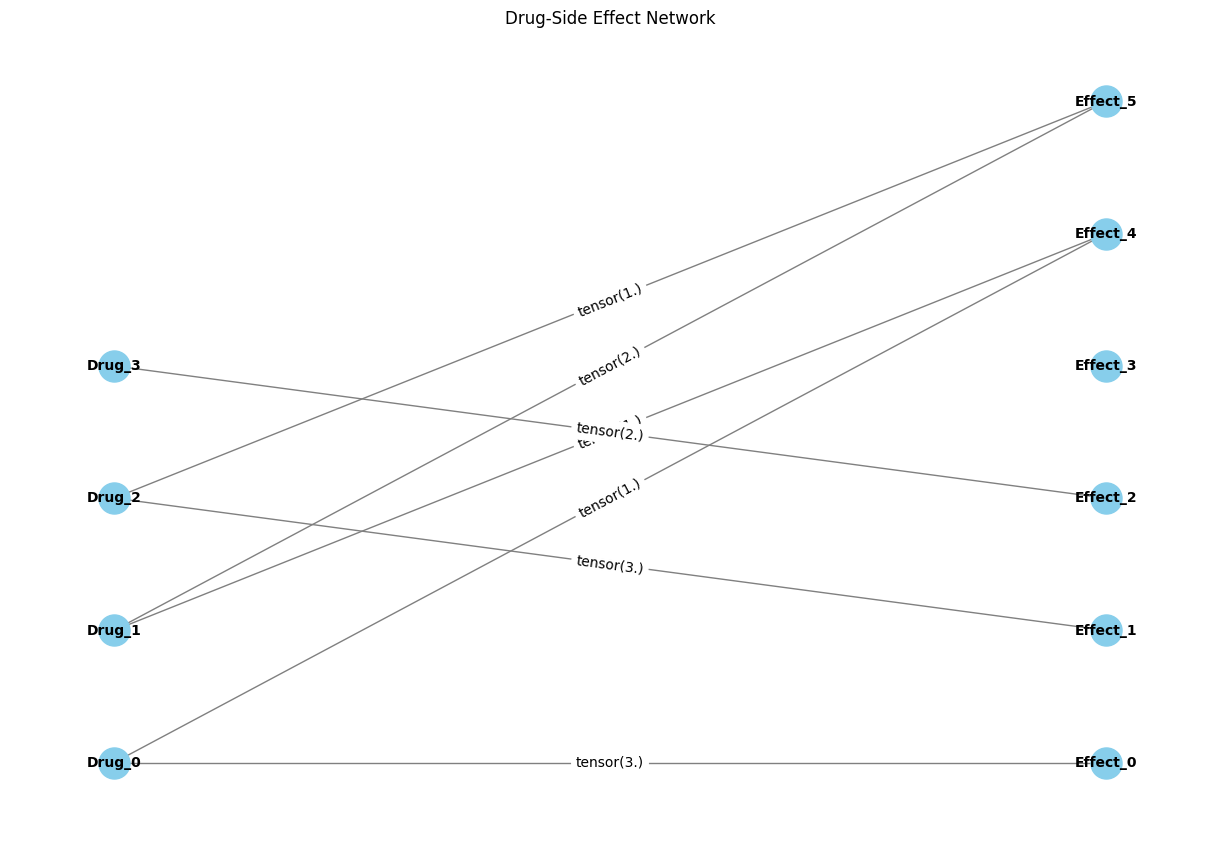

In [201]:
n_drugs, n_effects = Aij.shape
G = nx.Graph()

# Add nodes for drugs and side effects
for i in range(n_drugs):
    G.add_node(f"Drug_{i}", bipartite=0)
for j in range(n_effects):
    G.add_node(f"Effect_{j}", bipartite=1)

# Add edges based on Aij (non-zero values are links)
for i in range(n_drugs):
    for j in range(n_effects):
        if Aij[i, j] != 0:  # Only link if Aij[i, j] != 0
            G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=Aij[i, j])

pos = {}
pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(n_drugs)))  # Position for drugs
pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(n_effects)))  # Position for effects

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Display edge weights (optional)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title('Drug-Side Effect Network')
plt.show()

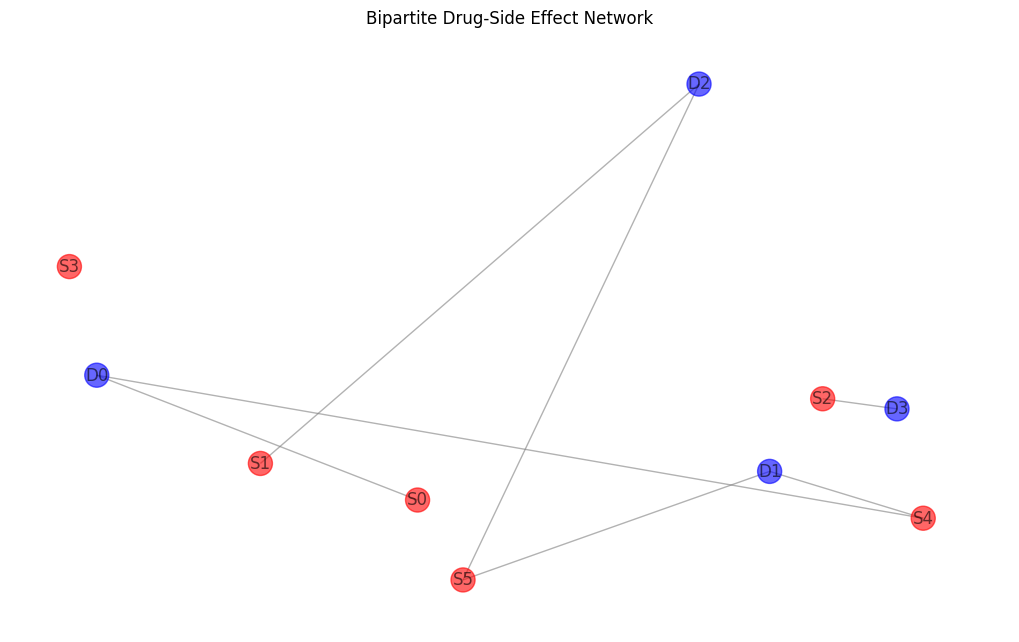

In [203]:
n_drugs, n_effects = Aij.shape
G = nx.Graph()

# Add nodes for drugs and side effects
for i in range(wcn.shape[0]):
    G.add_node(f"D{i}", bipartite=0, pos=w_2d[i])

# Add side effect nodes
for j in range(vcn.shape[0]):
    G.add_node(f"S{j}", bipartite=1, pos=v_2d[j])

# Add edges based on Aij (non-zero values are links)
for i in range(n_drugs):
    for j in range(n_effects):
        if Aij[i, j] != 0:  # Only link if Aij[i, j] != 0
            G.add_edge(f"D{i}", f"S{j}", weight=Aij[i, j])

pos = nx.get_node_attributes(G, "pos")

# Draw network
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color=["blue" if "D" in node else "red" for node in G.nodes], edge_color="gray", alpha=0.6)
plt.title("Bipartite Drug-Side Effect Network")
plt.show()